# Часть 1. Работа с датасетом и преобразование данных для обучения

В данной работе был использован датасет, содержащий в себе произведения трёх хоррор-писателей: Эдгара Аллана По (аббревиатура - EAP), Мэри Уолстонкрафт Шэлли (аббревиатура - MWS) и Говарда Филлипса Лавкрафта (аббревиатура - HPL)

## Импорт библиотек и данных

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import seaborn as sns

labelencoder = LabelEncoder()


In [3]:
#!pip install keras

In [4]:
#!pip install tensorflow

In [5]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

print('Train shape:',data_train.shape)
print('Test shape:',data_test.shape)

Train shape: (19579, 3)
Test shape: (8392, 2)


In [6]:
data_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


##  Нормализация текста

In [7]:
StopWords = set(stopwords.words('english'))

def text_preprocess(text):
    trans = str.maketrans('','',string.punctuation)
    text = text.translate(trans)
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in StopWords])
    return text

data_train['text'] = data_train['text'].apply(text_preprocess)
data_test['text'] = data_test['text'].apply(text_preprocess)
data_train.head()

,id,text,author
0,id26305,process however afforded means ascertaining di...,EAP
1,id17569,never occurred fumbling might mere mistake,HPL
2,id11008,left hand gold snuff box capered hill cutting ...,EAP
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS
4,id12958,finding nothing else even gold superintendent ...,HPL


# Визуализация

## Bar-Plot (Столбцовая диаграмма)

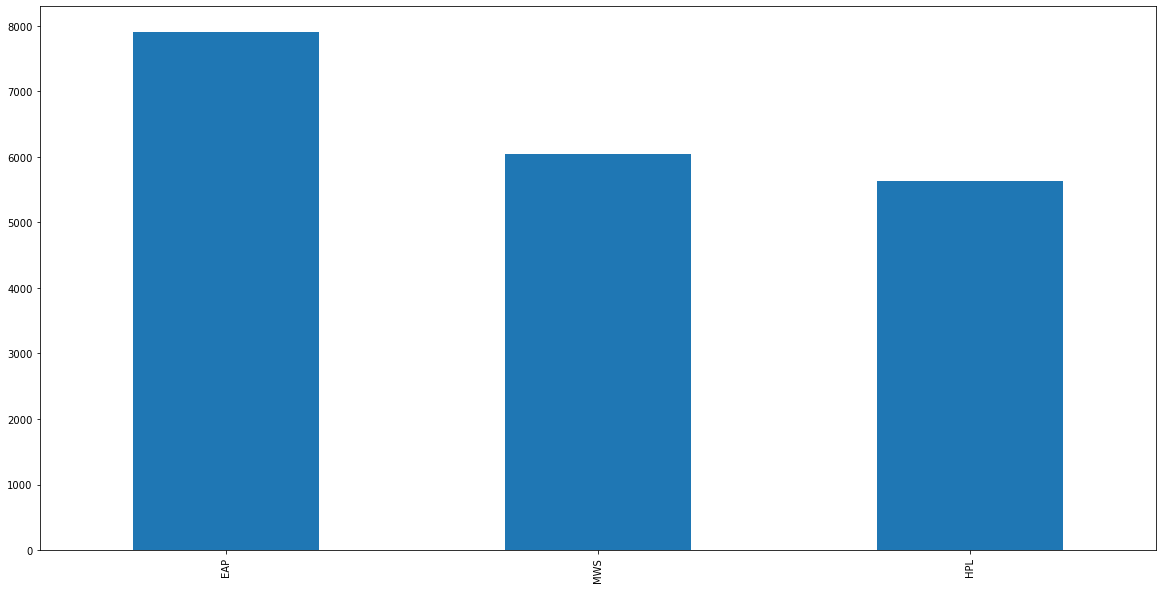

In [8]:
plt.figure(figsize = (20,10))
data_train['author'].value_counts().plot(kind = 'bar')

## Violin-Plot (Скрипичная диаграмма)

In [9]:
data_train['num_words'] = data_train['text'].apply(lambda x : len(str(x).split()))
data_test['num_words'] = data_test['text'].apply(lambda x : len(str(x).split()))

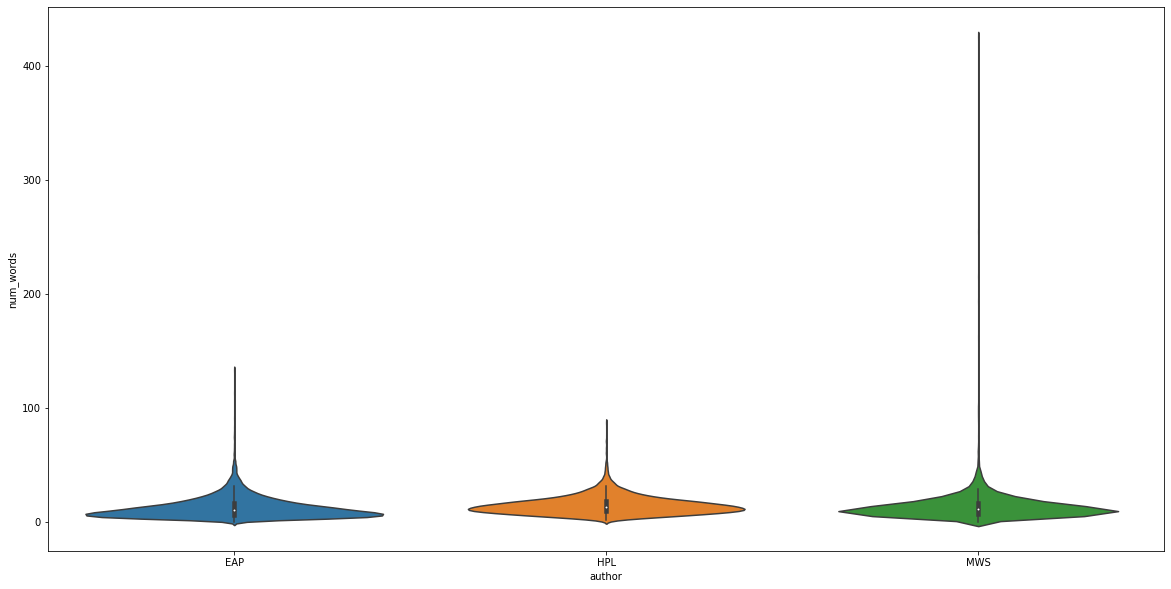

In [10]:
plt.figure(figsize = (20,10))
sns.violinplot(x = 'author' , y = 'num_words' , data = data_train)

## WordCloud

In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
df = pd.read_csv("train.csv")

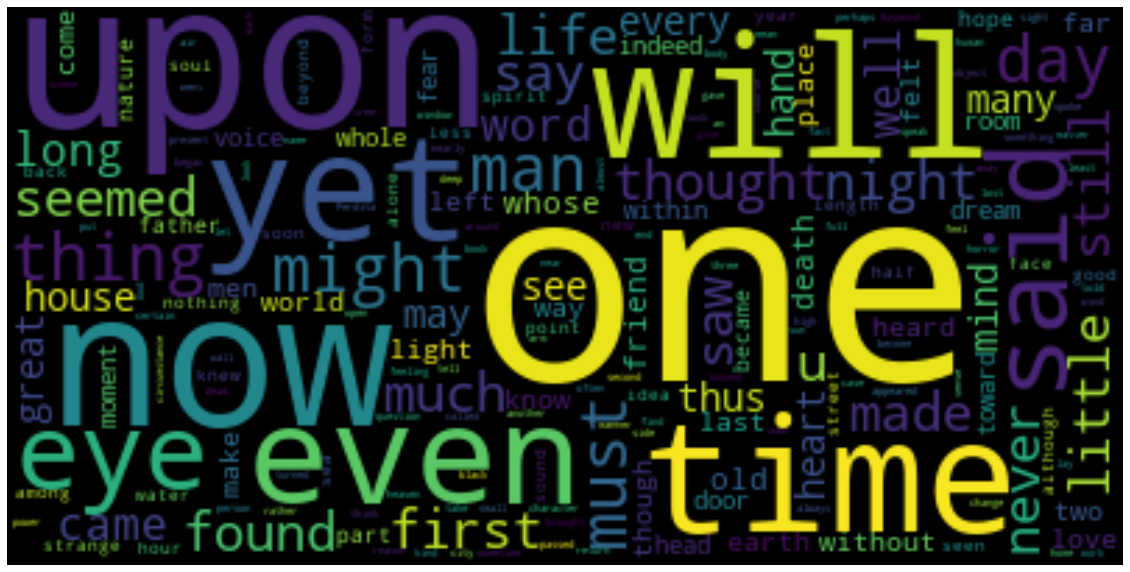

In [13]:
text = df["text"].str.cat()
plt.figure(figsize = (20, 20))
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Часть 2. Семантическая обработка литературного текста и построение нейронной сети на основе Keras API (TensorFlow)

## Токенизация и Лемматизация

Токенизация — это самый первый шаг при обработке текста. Заключается в разбиении (разделении) длинных строк текста в более мелкие: абзацы делим на предложения, предложения на слова.

Лемматизация — близка к стеммизации. Отличие в том, что лемматизация приводит слово к смысловой канонической форме слова (инфинитив для глагола, именительный падеж единственного числа — для существительных и прилагательных). Это более сложная операция. Например: зафрахтованный — фрахтовать,  ценами — цена, лучший — хороший.

In [14]:
label_encoder = LabelEncoder()
X_train = data_train['text']
X_train = X_train.tolist()
X_test = data_test['text']
X_test = X_test.tolist()
y_train = data_train['author']
y_train = label_encoder.fit_transform(y_train)
y_train_cat = ku.to_categorical(y_train, num_classes=3)
val_id = data_test['id']

lemmatizer = WordNetLemmatizer()
X_train_lemm = []
for text in X_train:
    lem_text = ''
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word, pos='v')
        lem_word = lemmatizer.lemmatize(lem_word)
        lem_text = lem_text + ' ' + lem_word
    X_train_lemm.append(lem_text)

X_test_lemm = []
for text in X_test:
    lem_text = ''
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word, pos='v')
        lem_word = lemmatizer.lemmatize(lem_word)
        lem_text = lem_text + ' ' + lem_word
    X_test_lemm.append(lem_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lemm)
vocab_size = len(tokenizer.word_index)
max_len = 150
train_seq = tokenizer.texts_to_sequences(X_train_lemm)
train_pad = pad_sequences(train_seq, maxlen=max_len)
test_seq = tokenizer.texts_to_sequences(X_test_lemm)
test_pad = pad_sequences(test_seq, maxlen=max_len)

label2idx = {
    'EAP': 0,
    'HPL': 1,
    'MWS': 2
}

In [15]:
#import nltk
#nltk.download('wordnet')

## Обучение с использованием методов TF-IDF и Vectorizer

In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform(X_train_lemm)
X_test_tfidf = tfidf.transform(X_test_lemm)

In [17]:
clf = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print(y_pred)
output_prob = clf.predict_proba(X_test_tfidf)
output_prob[:,0]

[2 0 1 ... 0 2 1]


array([0.18964984, 0.51297798, 0.37707126, ..., 0.64168639, 0.26446436,
       0.45248081])

## Обучение с использованием метода LSTM

LSTM-сеть — это искусственная нейронная сеть, содержащая LSTM-модули вместо или в дополнение к другим сетевым модулям. LSTM-модуль — это рекуррентный модуль сети, способный запоминать значения как на короткие, так и на длинные промежутки времени. Ключом к данной возможности является то, что LSTM-модуль не использует функцию активации внутри своих рекуррентных компонентов. Таким образом, хранимое значение не размывается во времени, и градиент или штраф не исчезает при использовании метода обратного распространения ошибки во времени (англ. Backpropagation through time) при обучении искусственной нейронной сети.

In [18]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, 300, input_length=max_len),
    keras.layers.SpatialDropout1D(0.5),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_pad, y_train_cat, epochs=5, batch_size=128)

Epoch 1/5
 49/153 [========>.....................] - ETA: 2:56 - loss: 0.9873 - accuracy: 0.4824

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
y_pred_nn = model.predict_classes(test_pad)
print(y_pred_nn)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([y_pred], [y_pred_nn])

### Вывод по обучению

Мы обучили логит-модель, нейронную сеть, а так же вывели значимость слов в нашем датасете при помощи метода TF-IDF. Нейронная сеть, в отличии от простых моделей классификации и регрессии, способна показать уровни точности, приближённый к абсолютным 100%. Такой уровень предсказаний связан с комплексностью построения моделей такого типа и их глубиной обучения. Как правило, ключевыми покзателями, от которых зависит точность предсказаний, являются Эры (epochs) и размеры партии (batch_size). Оба аргумента являются гиперпараметрами, необходимыми для корректного обучения. Количество Эр определяется размером датасета и может достигать 1000 для крупных систем. Поскольку процесс обучения нейронных сетей занимает довольно продолжительное время, большое количество Эр в данной работе нецелесообразно. Даже с пятью проходами, модель способна показать очень высокий уровень точности. Размеры партии определяются желаемой точностью прогнозирования и варьируются от 8 до 64 (эквивалентная битность целочисленного типа данных). Однако, при желании можно использовать любой размер партии, соответствующий битности (128, 256, 512 и так далее). 